# Overview
Train classifier on x acceleration features only. Binary classification. Does not account for balancing data. Strictly reads in data and trains MLP classifier using all tsfel features

# IMPORTANT: READ IN FEATURES. DO NOT RUN ALL CODE. JUMP to <a href="#section1">HERE</a>

In [67]:
import os
import tsfel
import numpy as np
import pandas as pd
import re

### Set directory locations

In [68]:
norm_dir = './Data/Normal_data'
tremor_4_dir = './Data/Tremor_added/4Hz'
tremor_8_dir = './Data/Tremor_added/8Hz'
test_dir = './Data/tremor_test_data'
test_dir_normal = './Data/normal_test_data'

### Helper functions


In [69]:
"""
Given an amplitude string, return numeric scale rating. Assumes cm and mm used.
"""
def get_scale(measurement):
    try:
        value = float(measurement[:-2])
        units = measurement[-2:]
        if value==0:
            return 0
        if units=='mm':
            if value<100:
                return 1
            else:
                # should be measured in cm
                return -1
        elif units=='cm':
            if value<1:
                return 1
            elif value>=1 and value<3:
                return 2
            elif value>=3 and value<10:
                return 3
            else:
                return 4
        # wrong units
        return -1
    except:
        print(measurement)
        print("An exception occured and the measurement is not supported", value, units)
        return -1
"""
Read in data given a directory and if the directory is for tremor data or not. Return a df with an amplitude column and 
severity. Severity is gathered from file name.
"""
def read_data(directory, tremor=False):
    df = pd.DataFrame()
    for f in os.listdir(directory):
        df_temp = pd.read_csv(directory+'/'+f, header=0, names=["x", "y", "z"])
        if tremor:
            exp = re.compile(r'[^_]+_[^_]+$')
            amp = exp.findall(f)[0][:-8]
            df_temp['amplitude'] = amp
            df_temp['severity'] = get_scale(amp)
        else:
            df_temp['amplitude'] = '0cm'
            df_temp['severity'] = get_scale('0cm')
        df = pd.concat([df, df_temp])
    return df 

"""
Extract all features from the data.

****Parameters
train_df: dataframe with x, y, z accelerometer data
severity: int severity on UPDRS scale
fs: sampling frequency
window_size: fs*seconds, 200 means 20*10, so 10 second windows

****Return
trained: dataframe with all features and severity column

"""
def extract_features_by_severity(train_df, severity, fs=20, window_size=200, axis="x"):
    temp = train_df[axis].to_frame()
    cfg_file = tsfel.get_features_by_domain()  
    trained = tsfel.time_series_features_extractor(cfg_file, temp, fs=fs, window_size=window_size)
    trained['severity'] = severity
    return trained

### Read in Data. Directories specified above

In [70]:
df_norm = read_data(norm_dir)

In [71]:
df_norm.head()

x         y           z amplitude  severity
1600 A 90426757696641  4.972757 -0.158317  6.6967316;       0cm         0
       90426807196641  3.253720 -0.191835   6.107758;       0cm         0
       90426856696641  2.801216 -0.155922   5.997625;       0cm         0
       90426906196641  3.770868 -1.051354   7.731027;       0cm         0
       90426955696641  4.661511  0.169689   9.684695;       0cm         0

In [72]:
df_norm.reset_index(drop=True, inplace=True)
df_norm.head()

,x,y,z,amplitude,severity
0,4.972757,-0.158317,6.6967316;,0cm,0
1,3.253720,-0.191835,6.107758;,0cm,0
2,2.801216,-0.155922,5.997625;,0cm,0
3,3.770868,-1.051354,7.731027;,0cm,0
4,4.661511,0.169689,9.684695;,0cm,0


In [73]:
df_4hz = read_data(tremor_4_dir, tremor=True)

In [74]:
df_4hz.head()

,x,y,z,amplitude,severity
0,-55.101173,-60.232247,-53.377199,10cm,4
1,-33.874011,-37.319566,-31.019973,10cm,4
2,39.928947,36.971808,43.125356,10cm,4
3,63.844798,59.022576,67.804957,10cm,4
4,4.661511,0.169689,9.684695,10cm,4


In [46]:
#n_size = df_4hz.groupby(['severity']).size().min()
#df_4hz = df_4hz.groupby('severity', as_index=False).apply(lambda x: x.sample(n= n_size))
#df_4hz.reset_index(drop=True, inplace=True)

In [47]:
#df_4hz = df_4hz.groupby('severity', as_index=False).apply(lambda x: x.sample(n= n_size))

In [49]:
#df_4hz.reset_index(drop=True, inplace=True)

### Extract features for normal and 4hz dataframes. 

In [75]:
%%time
X_train_norm = extract_features_by_severity(df_norm, severity=0)

*** Feature extraction started ***



*** Feature extraction finished ***
Wall time: 2min 52s


In [76]:
X_train_norm.to_csv('saved_norm_x.csv', index=False)

In [77]:
%%time
df_grouped_4hz = df_4hz.groupby(["severity"])

Wall time: 1e+03 µs


In [78]:
_4hz_groups = [df_grouped_4hz.get_group(x) for x in df_grouped_4hz.groups]
trained_4hz_frames = []
for df in _4hz_groups:
    trained_4hz_frames.append(extract_features_by_severity(df, df["severity"].iloc[0]))

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


### Join all severity dataframes together for 4hz.

In [79]:
df_4hz_joined = pd.concat(trained_4hz_frames, ignore_index=True)

In [80]:
df_4hz_joined.to_csv('saved_4hz_all.csv', index=False)

In [81]:
X_train_norm.shape

(3328, 236)

In [82]:
df_4hz_joined.shape

(8468, 236)

### Combine all feature dataframes into one.

In [83]:
df_x_features = pd.concat([X_train_norm, df_4hz_joined], ignore_index=True)

In [84]:
df_x_features.to_csv('saved_features.csv', index=False)

In [85]:
df_x_features

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,32706.547340,120.651156,32706.547340,5.258573,40.0,160.0,8.293514,15.732300,0.005,0.01,...,33.549756,54.615097,59.839033,64.151396,58.447217,45.540403,35.081710,31.245857,0.0,0
1,31265.738556,120.502865,31265.738556,4.855203,40.0,160.0,9.402030,14.460978,0.005,0.01,...,21.401843,29.617800,36.056555,45.380055,47.727731,44.125786,40.894024,41.280500,0.0,0
2,31294.233201,120.875463,31294.233201,4.872443,40.0,160.0,9.334992,14.858416,0.005,0.01,...,23.898359,33.588663,38.294527,46.768419,49.055807,45.235522,41.550160,41.482886,0.0,0
3,30713.108732,119.027738,30713.108732,5.104300,40.0,160.0,8.710106,14.329297,0.005,0.01,...,29.582273,48.559945,55.129474,63.237796,61.395971,50.875834,41.364797,37.828333,0.0,0
4,30571.705492,119.850445,30571.705492,5.272381,40.0,160.0,9.392453,14.489709,0.005,0.01,...,16.350803,31.195999,41.947704,50.059430,48.739978,41.516780,36.194489,35.631017,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,411944.697362,327.400986,411944.697362,5.023920,40.0,160.0,-46.022959,50.838726,0.005,0.01,...,1398.839211,43.296967,34.194890,33.038539,35.735072,40.295345,45.937751,52.670699,80.0,4
11792,406539.609694,324.034350,406539.609694,5.006629,40.0,160.0,-45.436380,56.610548,0.005,0.01,...,1384.704285,41.988070,48.055432,61.874325,73.102150,78.330487,79.754251,82.167519,80.0,4
11793,407227.767753,325.422897,407227.767753,5.006682,40.0,160.0,-47.682141,49.727816,0.005,0.01,...,1374.070479,50.338629,50.972835,43.797819,33.110262,27.040933,26.177861,28.426770,80.0,4
11794,411043.748906,326.031563,411043.748906,5.042889,40.0,160.0,-46.863323,50.874638,0.005,0.01,...,1393.056674,34.178444,34.021331,39.374304,44.651556,48.848590,50.843832,51.186100,80.0,4


In [86]:
df_test1 = read_data(test_dir, tremor=True)
df_test2 = read_data(test_dir_normal, tremor=False)
df_test = pd.concat([df_test1, df_test2], ignore_index=True)

In [87]:
df_test_grouped = df_test.groupby(["severity"])
df_test_grouped.head()

,x,y,z,amplitude,severity
0,-7.058258,-10.613797,-0.098014,1.29cm,2
1,-4.546773,-7.132660,2.808514,1.29cm,2
2,4.943911,2.623780,12.224977,1.29cm,2
3,7.919871,6.195896,15.861738,1.29cm,2
4,0.694169,-1.250073,8.736591,1.29cm,2
194952,-26.543523,-30.099062,-19.583279,4.53cm,3
194953,-16.589329,-19.175216,-9.234042,4.53cm,3
194954,16.986467,14.666336,24.267533,4.53cm,3
194955,27.405136,25.681161,35.347003,4.53cm,3
194956,0.694169,-1.250073,8.736591,4.53cm,3


In [88]:
test_groups = [df_test_grouped.get_group(x) for x in df_test_grouped.groups]
trained_test_frames = []
for df in test_groups:
    trained_test_frames.append(extract_features_by_severity(df, df["severity"].iloc[0]))

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [89]:
df_test_joined = pd.concat(trained_test_frames, ignore_index=True)
df_test_joined.to_csv('test_features.csv', index=False)

In [91]:
df_test_joined

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,1.876972e+04,83.074520,1.876972e+04,4.461759,40.0,160.0,2.225411,12.537237,0.005,0.01,...,26.616124,28.080062,27.605879,38.675763,54.936328,74.739804,99.296742,129.974362,6.0,0
1,2.807373e+04,114.809424,2.807373e+04,5.060721,40.0,160.0,9.575610,13.837289,0.005,0.01,...,18.780244,21.771255,22.788332,24.422470,23.800331,22.675082,23.085912,25.261421,0.0,0
2,1.134207e+04,60.063099,1.134207e+04,2.570839,40.0,160.0,-2.610877,10.370484,0.005,0.01,...,20.876211,27.854787,31.840493,41.025266,47.673504,49.485521,49.127337,49.662318,15.0,0
3,6.693110e+02,11.554418,6.693110e+02,3.886726,40.0,160.0,-2.086547,0.147243,0.005,0.01,...,5.385276,3.576644,1.510396,1.089157,1.046845,1.030507,1.066662,1.151484,58.0,0
4,4.930398e+02,10.667366,4.930398e+02,5.436123,40.0,160.0,-1.622072,-0.032322,0.005,0.01,...,3.138870,2.638352,2.762922,3.127169,2.994078,2.614922,2.426145,2.593130,42.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51571,1.286573e+06,568.816172,1.286573e+06,4.938976,40.0,160.0,-102.320320,74.888333,0.005,0.01,...,4497.559609,92.664412,66.992124,65.299198,63.554233,62.806434,65.149446,70.857581,80.0,4
51572,1.297072e+06,573.076280,1.297072e+06,4.948299,40.0,160.0,-100.074559,75.400692,0.005,0.01,...,4547.205846,98.648297,78.106064,86.437538,88.835843,82.369687,71.339866,60.127224,79.0,4
51573,1.287305e+06,570.804138,1.287305e+06,4.944916,40.0,160.0,-101.329120,68.361739,0.005,0.01,...,4497.775489,76.288498,47.879153,42.765175,43.795864,48.792111,54.467353,59.494105,80.0,4
51574,1.298359e+06,573.082610,1.298359e+06,4.951635,40.0,160.0,-88.197523,82.892150,0.005,0.01,...,4564.364657,149.265324,136.421816,125.568938,119.260063,125.479576,137.318956,146.142819,79.0,4


<a id="section1"></a>
# READ IN FEATURES FROM CSV SO ABOVE CODE DOES NOT NEED TO BE RUN. UNCOMMENT BELOW CELL


In [92]:
df_x_features = pd.read_csv('saved_features.csv')
df_test_features = pd.read_csv('test_features.csv')

In [93]:
df_x_features

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,32706.547340,120.651156,32706.547340,5.258573,40.0,160.0,8.293514,15.732300,0.005,0.01,...,33.549756,54.615097,59.839033,64.151396,58.447217,45.540403,35.081710,31.245857,0.0,0
1,31265.738556,120.502865,31265.738556,4.855203,40.0,160.0,9.402030,14.460978,0.005,0.01,...,21.401843,29.617800,36.056555,45.380055,47.727731,44.125786,40.894024,41.280500,0.0,0
2,31294.233201,120.875463,31294.233201,4.872443,40.0,160.0,9.334992,14.858416,0.005,0.01,...,23.898359,33.588663,38.294527,46.768419,49.055807,45.235522,41.550160,41.482886,0.0,0
3,30713.108732,119.027738,30713.108732,5.104300,40.0,160.0,8.710106,14.329297,0.005,0.01,...,29.582273,48.559945,55.129474,63.237796,61.395971,50.875834,41.364797,37.828333,0.0,0
4,30571.705492,119.850445,30571.705492,5.272381,40.0,160.0,9.392453,14.489709,0.005,0.01,...,16.350803,31.195999,41.947704,50.059430,48.739978,41.516780,36.194489,35.631017,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11791,411944.697362,327.400986,411944.697362,5.023920,40.0,160.0,-46.022959,50.838726,0.005,0.01,...,1398.839211,43.296967,34.194890,33.038539,35.735072,40.295345,45.937751,52.670699,80.0,4
11792,406539.609694,324.034350,406539.609694,5.006629,40.0,160.0,-45.436380,56.610548,0.005,0.01,...,1384.704285,41.988070,48.055432,61.874325,73.102150,78.330487,79.754251,82.167519,80.0,4
11793,407227.767753,325.422897,407227.767753,5.006682,40.0,160.0,-47.682141,49.727816,0.005,0.01,...,1374.070479,50.338629,50.972835,43.797819,33.110262,27.040933,26.177861,28.426770,80.0,4
11794,411043.748906,326.031563,411043.748906,5.042889,40.0,160.0,-46.863323,50.874638,0.005,0.01,...,1393.056674,34.178444,34.021331,39.374304,44.651556,48.848590,50.843832,51.186100,80.0,4


In [94]:
df_test_features

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,1.876972e+04,83.074520,1.876972e+04,4.461759,40.0,160.0,2.225411,12.537237,0.005,0.01,...,26.616124,28.080062,27.605879,38.675763,54.936328,74.739804,99.296742,129.974362,6.0,0
1,2.807373e+04,114.809424,2.807373e+04,5.060721,40.0,160.0,9.575610,13.837289,0.005,0.01,...,18.780244,21.771255,22.788332,24.422470,23.800331,22.675082,23.085912,25.261421,0.0,0
2,1.134207e+04,60.063099,1.134207e+04,2.570839,40.0,160.0,-2.610877,10.370484,0.005,0.01,...,20.876211,27.854787,31.840493,41.025266,47.673504,49.485521,49.127337,49.662318,15.0,0
3,6.693110e+02,11.554418,6.693110e+02,3.886726,40.0,160.0,-2.086547,0.147243,0.005,0.01,...,5.385276,3.576644,1.510396,1.089157,1.046845,1.030507,1.066662,1.151484,58.0,0
4,4.930398e+02,10.667366,4.930398e+02,5.436123,40.0,160.0,-1.622072,-0.032322,0.005,0.01,...,3.138870,2.638352,2.762922,3.127169,2.994078,2.614922,2.426145,2.593130,42.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51571,1.286573e+06,568.816172,1.286573e+06,4.938976,40.0,160.0,-102.320320,74.888333,0.005,0.01,...,4497.559609,92.664412,66.992124,65.299198,63.554233,62.806434,65.149446,70.857581,80.0,4
51572,1.297072e+06,573.076280,1.297072e+06,4.948299,40.0,160.0,-100.074559,75.400692,0.005,0.01,...,4547.205846,98.648297,78.106064,86.437538,88.835843,82.369687,71.339866,60.127224,79.0,4
51573,1.287305e+06,570.804138,1.287305e+06,4.944916,40.0,160.0,-101.329120,68.361739,0.005,0.01,...,4497.775489,76.288498,47.879153,42.765175,43.795864,48.792111,54.467353,59.494105,80.0,4
51574,1.298359e+06,573.082610,1.298359e+06,4.951635,40.0,160.0,-88.197523,82.892150,0.005,0.01,...,4564.364657,149.265324,136.421816,125.568938,119.260063,125.479576,137.318956,146.142819,79.0,4


In [47]:
df_x_features

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,27732.781873,111.031590,27732.781873,4.984086,40.0,160.0,7.646931,14.602086,0.005,0.01,...,56.982427,79.979403,42.869385,21.151390,18.431262,19.359709,21.512083,25.098152,0.0,0
1,93.351649,6.778509,93.351649,5.258267,40.0,160.0,-0.723348,-0.637157,0.005,0.01,...,0.007598,0.013634,0.023203,0.036438,0.053330,0.073054,0.094433,0.116439,0.0,0
2,9944.654220,64.956738,9944.654220,6.168371,40.0,160.0,-8.460959,-2.427720,0.005,0.01,...,1.067184,2.511725,4.730646,7.613422,11.044084,14.922400,19.130449,23.504892,0.0,0
3,17706.658100,93.620508,17706.658100,4.974739,40.0,160.0,9.370157,9.446772,0.005,0.01,...,1.166850,2.525349,4.342613,6.567605,9.172780,12.128984,15.401834,18.952938,0.0,0
4,24783.349032,104.714257,24783.349032,5.077199,40.0,160.0,7.120655,13.683162,0.005,0.01,...,48.294797,64.911613,35.639450,18.131489,16.415047,17.934739,19.753930,22.029567,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16931,411944.697362,327.400986,411944.697362,5.023920,40.0,160.0,-46.022959,50.838726,0.005,0.01,...,1398.839211,43.296967,34.194890,33.038539,35.735072,40.295345,45.937751,52.670699,80.0,4
16932,406539.609694,324.034350,406539.609694,5.006629,40.0,160.0,-45.436380,56.610548,0.005,0.01,...,1384.704285,41.988070,48.055432,61.874325,73.102150,78.330487,79.754251,82.167519,80.0,4
16933,407227.767753,325.422897,407227.767753,5.006682,40.0,160.0,-47.682141,49.727816,0.005,0.01,...,1374.070479,50.338629,50.972835,43.797819,33.110262,27.040933,26.177861,28.426770,80.0,4
16934,411043.748906,326.031563,411043.748906,5.042889,40.0,160.0,-46.863323,50.874638,0.005,0.01,...,1393.056674,34.178444,34.021331,39.374304,44.651556,48.848590,50.843832,51.186100,80.0,4


# Equalize classes for test and training

In [95]:
n_size = df_x_features.groupby(['severity']).size().min()
n_size

651

In [96]:
df_x_features = df_x_features.groupby('severity', as_index=False).apply(lambda x: x.sample(n= n_size))
df_x_features.reset_index(drop=True, inplace=True)

In [97]:
n_size = df_test_features.groupby(['severity']).size().min()
n_size

1310

In [98]:
df_test_features = df_test_features.groupby('severity', as_index=False).apply(lambda x: x.sample(n= n_size))
df_test_features.reset_index(drop=True, inplace=True)

In [102]:
df_x_features.groupby('severity').size()

severity
0    651
1    651
2    651
3    651
4    651
dtype: int64

In [103]:
df_test_features.groupby('severity').size()

severity
0    1310
1    1310
2    1310
3    1310
4    1310
dtype: int64

### Remove label column for scaling

In [104]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [105]:
x = df_x_features.drop('severity', axis=1).values
columns = df_x_features.drop('severity', axis=1).columns
sc = StandardScaler()

x_test = df_test_features.drop('severity', axis=1).values
test_columns = df_test_features.drop('severity', axis=1).columns

### Use sklearn standard scaler. Apparently better than normalizing for classification.
Drops label and then adds back to avoid scaling the label.
Note: Normalization is better for regression tasks.

In [106]:
%%time
x_scaled = sc.fit_transform(x)
df_x_features_scaled = pd.DataFrame(x_scaled, columns=columns)
df_x_features_scaled['severity'] = df_x_features['severity']

x_test_scaled = sc.transform(x_test)
df_x_test_features_scaled = pd.DataFrame(x_test_scaled, columns=test_columns)
df_x_test_features_scaled['severity'] = df_test_features['severity']

Wall time: 18 ms


In [107]:
df_x_features_scaled

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,-0.763832,-1.059381,-0.763832,-2.538610,0.0,0.0,0.986181,-0.777881,1.0,1.0,...,-0.750336,-0.593133,-0.564078,-0.615863,-0.599277,-0.515641,-0.470836,-0.448061,-1.552541,0
1,-0.770448,-1.179913,-0.770448,1.333663,0.0,0.0,0.930736,-0.890848,1.0,1.0,...,-0.750366,-0.594057,-0.566510,-0.621497,-0.608447,-0.526345,-0.482877,-0.461872,-1.552541,0
2,-0.771073,-1.195125,-0.771073,0.181099,0.0,0.0,0.936955,-0.909891,1.0,1.0,...,-0.750464,-0.595248,-0.567987,-0.623789,-0.611584,-0.529783,-0.486538,-0.465724,-1.552541,0
3,-0.655893,-0.459966,-0.655893,0.949589,0.0,0.0,1.228068,-0.308698,1.0,1.0,...,-0.732545,-0.369182,-0.287750,-0.189213,0.000362,0.151994,0.240400,0.292738,-1.552541,0
4,-0.686349,-0.630472,-0.686349,0.371551,0.0,0.0,0.456039,-1.336040,1.0,1.0,...,-0.714921,-0.372283,-0.364494,-0.399340,-0.396226,-0.357168,-0.341737,-0.337205,-0.716192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,1.806853,1.689049,1.806853,-0.113880,0.0,0.0,-2.175685,0.713898,1.0,1.0,...,1.735996,-0.322639,-0.391899,-0.385141,-0.318294,-0.248335,-0.224552,-0.220888,0.837028,4
3251,1.822005,1.666952,1.822005,-0.107089,0.0,0.0,-1.528192,1.374076,1.0,1.0,...,2.032076,2.406286,1.449106,0.720527,0.441644,0.356432,0.285862,0.206723,0.807159,4
3252,1.716080,1.539984,1.716080,-0.052303,0.0,0.0,-1.804758,1.205501,1.0,1.0,...,1.747653,-0.305437,-0.396599,-0.425137,-0.407387,-0.365058,-0.355341,-0.358569,0.837028,4
3253,1.795477,1.659792,1.795477,-0.008845,0.0,0.0,-1.141515,1.889139,1.0,1.0,...,1.784600,0.268594,0.244744,0.273434,0.199655,0.096467,0.039370,0.009065,0.807159,4


In [108]:
df_x_test_features_scaled

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,0_Wavelet variance_1,0_Wavelet variance_2,0_Wavelet variance_3,0_Wavelet variance_4,0_Wavelet variance_5,0_Wavelet variance_6,0_Wavelet variance_7,0_Wavelet variance_8,0_Zero crossing rate,severity
0,-0.669386,-0.470931,-0.669386,-0.116866,0.0,0.0,0.477143,-1.479564,1.0,1.0,...,-0.747753,-0.562294,-0.515819,-0.525507,-0.465150,-0.369049,-0.319326,-0.292294,-1.552541,0
1,-0.641143,-0.460493,-0.641143,0.478127,0.0,0.0,0.673064,-0.268473,1.0,1.0,...,-0.690348,0.130743,0.764136,2.255878,4.069945,4.946810,5.579950,6.206216,-1.373324,0
2,-0.760997,-1.034305,-0.760997,0.093379,0.0,0.0,0.710304,-1.068497,1.0,1.0,...,-0.749758,-0.579452,-0.534892,-0.550196,-0.489063,-0.386141,-0.331813,-0.303716,-1.552541,0
3,-0.751342,-0.932915,-0.751342,-2.532010,0.0,0.0,0.679642,-1.116276,1.0,1.0,...,-0.749825,-0.584805,-0.549812,-0.585981,-0.552538,-0.465846,-0.423361,-0.404555,-1.552541,0
4,-0.601428,-0.320682,-0.601428,0.319908,0.0,0.0,1.176430,-0.132493,1.0,1.0,...,-0.621687,-0.027239,-0.233242,-0.236713,-0.192486,-0.162434,-0.156351,-0.151590,-1.552541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6545,3.972394,2.675553,3.972394,0.003184,0.0,0.0,-2.883258,1.934084,1.0,1.0,...,4.035315,0.069542,-0.140676,-0.095394,-0.034443,-0.042525,-0.083832,-0.124700,0.807159,4
6546,5.172646,3.219587,5.172646,-0.017759,0.0,0.0,-2.559823,3.179704,1.0,1.0,...,5.132710,0.555609,0.199828,0.212344,0.267205,0.202791,0.117870,0.055910,0.807159,4
6547,3.755429,2.518710,3.755429,0.014945,0.0,0.0,-2.783507,1.895525,1.0,1.0,...,3.674294,-0.360311,-0.498717,-0.558518,-0.552299,-0.485622,-0.453234,-0.439541,0.837028,4
6548,3.308695,2.451266,3.308695,-0.005313,0.0,0.0,-1.856889,2.652409,1.0,1.0,...,3.318163,0.352683,0.216293,0.500149,0.923082,1.111330,1.147370,1.098869,0.807159,4


In [109]:
#from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

### Set training and validation

In [110]:
training_set_x, validation_set_x = df_x_features_scaled, df_x_test_features_scaled

In [111]:
X_train_x = training_set_x.iloc[:,0:-1].values
Y_train_x = training_set_x.iloc[:,-1].values
X_val_x = validation_set_x.iloc[:,0:-1].values
y_val_x = validation_set_x.iloc[:,-1].values

In [112]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

In [113]:
from sklearn.neural_network import MLPClassifier

### Train classifier

In [114]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=10)

In [115]:
%%time
classifier.fit(X_train_x, Y_train_x)

Wall time: 2.18 s


MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=10)

### Evaluate prediction

In [116]:
y_pred_x = classifier.predict(X_val_x)

In [117]:
accuracy_score(y_val_x, y_pred_x, normalize=True, sample_weight=None)

0.8786259541984733

Confusion matrix, without normalization
[[1281   29    0    0    0]
 [ 201  931  178    0    0]
 [  14   13 1071  210    2]
 [   1    1   16 1163  129]
 [   0    0    0    1 1309]]
Normalized confusion matrix
[[9.77862595e-01 2.21374046e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.53435115e-01 7.10687023e-01 1.35877863e-01 0.00000000e+00
  0.00000000e+00]
 [1.06870229e-02 9.92366412e-03 8.17557252e-01 1.60305344e-01
  1.52671756e-03]
 [7.63358779e-04 7.63358779e-04 1.22137405e-02 8.87786260e-01
  9.84732824e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.63358779e-04
  9.99236641e-01]]


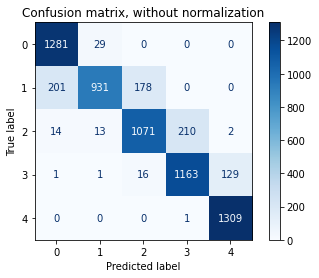

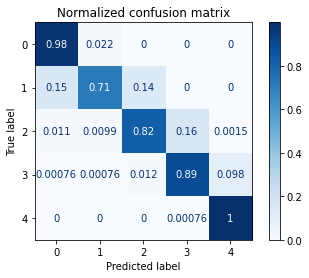

In [118]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_val_x, y_val_x,
                                 display_labels=[0,1,2,3,4],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)